In [1]:
"""
This loosely code follows the steps outlined by: 

https://cprosenjit.medium.com/multivariate-time-series-forecasting-using-xgboost-1728762a9eeb
"""

'\nThis loosely code follows the steps outlined by: \n\nhttps://cprosenjit.medium.com/multivariate-time-series-forecasting-using-xgboost-1728762a9eeb\n'

In [2]:
import numpy as np
import xgboost
import pandas as pd
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, RidgeCV

#14 Lines of import statements

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def format_data(path):
    df = pd.read_excel(path)
    df2 = df.drop(columns=['Country Name', 'Country Code'])
    df2 = df2.dropna(axis=1, how='all')
    
    return df2

In [5]:
def fill_na(data):
    
    df4 = data.fillna(data.mean())
    df4.drop(data.tail(1).index,inplace=True) #remove last row
    
    return df4

#4 lines written by me

In [6]:
def x_and_y(data):

    X = data.drop(columns='GDP growth (annual %)')
    y = data['GDP growth (annual %)']
    
    return X, y

#4 Lines written by me

In [7]:
def train_test_split_func(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
    
    return X_train, X_test, y_train, y_test

#3 Lines from documentation

In [8]:
def xgb(X_train, y_train, X_test, y_test):
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=1, learning_rate=0.15)
    model.fit(X_train, y_train, verbose=False)
            
    y_pred = model.predict(X_test)
    
    return model, y_pred

#5 lines from documentation

In [9]:
def scale(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    return X_train_s, X_test_s

#5 Lines from guide

In [10]:
"""
Modified from the guide:

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
"""

def feature_selection(model, X_train, X_test, y_train):
    
    selector = SelectFromModel(model, threshold=0.003)
    selector.fit (X_train, y_train)
    
    select_X_train = selector.transform(X_train)
    select_X_test = selector.transform(X_test)
    
    #print (selector.get_feature_names_out())
    
    selection_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, 
                                   max_depth=1, learning_rate = 0.1)
    selection_model.fit(select_X_train, y_train)
    
    select_y_pred = selection_model.predict(select_X_test)
    
    #modified from: https://stackoverflow.com/questions/54933804/how-to-get-actual-feature-names-in-xgboost-feature-importance-plot-without-retra
    selection_model.get_booster().feature_names = selector.get_feature_names_out().tolist()
    plot_importance(selection_model.get_booster())
    
    return select_X_test ,select_X_train ,select_y_pred

#11 lines of code taken from a guide and then modified

In [11]:
"""
This piece of code was reused from 
https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

"""

def tune_n_estimator(X, y):
    hyperparam = {'max_depth': [1,2,3,4,5,10],
                 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                 'n_estimators': [5,10,20,50,100,1000],
                 'lambda' : [1,2,3,4,5]}
    
    model = XGBRegressor()
    
    gscv = GridSearchCV(estimator=model, param_grid=hyperparam,
                       scoring='neg_mean_squared_error',
                       verbose=1)
    
    gscv.fit(X, y)
    
    print("best hyperparam:", gscv.best_params_)
    
#6 taken from guide

In [12]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)
    
#15 Lines. 3 From documentation, 3 from github, 9 written by me

In [13]:
#Get the data
data = format_data('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Multivariate More.xlsx')
filled = fill_na(data)
filled = filled.set_index('Year')

In [14]:
X, y = x_and_y(filled)
X_train, X_test, y_train, y_test = train_test_split_func(X, y)
X_train_scaled, X_test_scaled = scale(X_train, X_test)

In [15]:
"""Hyperparameter Tuning"""

#print("For select model: ", tune_n_estimator(select_X_train, y_train))
#print("For normal model: ", tune_n_estimator(X_train_scaled, y_train))

'Hyperparameter Tuning'

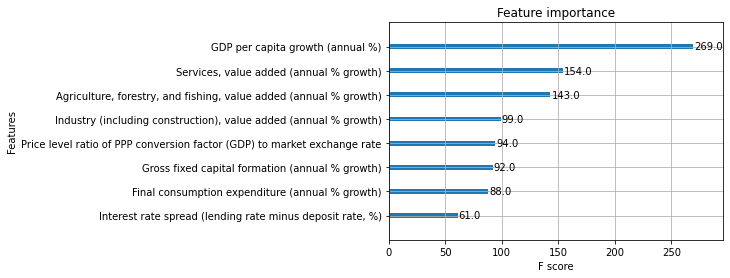

In [16]:
#Make prediction before feature selection, needed as we pass the model through to SelectFromModel
model, y_pred = xgb(X_train_scaled, y_train, X_test_scaled, y_test)

#Make predictions after feature selection
select_X_test ,select_X_train ,select_y_pred = feature_selection(model, X_train, X_test, y_train)

RMSE:  0.2570188387337305
MAPE:  3.418155275738619
MAE:  0.18135610627427878
Scatter Index:  4.7593295456996785
MDA:  0.9090909090909091
Mean of actual:  5.400316079519256


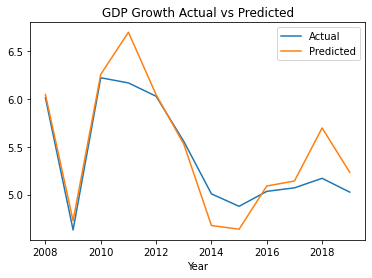

In [17]:
#Outputs
df_compare = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
df_compare.plot(title='GDP Growth Actual vs Predicted')
performance_metrics(y_test, y_pred)

Text(0.5, 1.0, 'Learning Curve for XGBoost After FS Before HT')

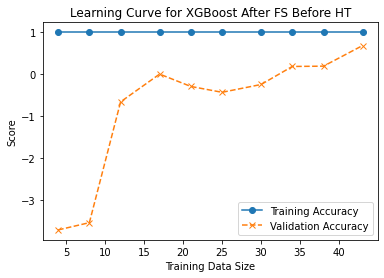

In [18]:
"""
Learning Curve to detect overfit/underfit

Method from: 

https://vitalflux.com/learning-curves-explained-python-sklearn-example/amp/
and
https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html#:~:text=Learning%20curves%20can%20be%20generated,see%20in%20the%20following%20examples.
"""

pipeline = make_pipeline(StandardScaler(), XGBRegressor(objective='reg:squarederror', n_estimators=1000, 
                                                        max_depth=6, learning_rate = 0.3))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=select_X_train,
                                                      y=y_train, cv=10,
                                                      train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, marker='o', label='Training Accuracy')
plt.xlabel('Training Data Size')
plt.plot(train_sizes, test_mean, marker='x', linestyle='--', label='Validation Accuracy')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve for XGBoost After FS Before HT')

#14 lines taken directly from guide, integrated with my model

In [19]:
train_mean

array([0.99999994, 0.99999994, 0.99999997, 0.99999997, 0.99999997,
       0.99999995, 0.99999994, 0.99999997, 0.99999996, 0.99999997])

In [20]:
test_mean

array([-3.72121482e+00, -3.54774479e+00, -6.62591271e-01,  3.60595470e-04,
       -2.94724093e-01, -4.34555477e-01, -2.47961330e-01,  1.82671066e-01,
        1.89896374e-01,  6.81431850e-01])

In [21]:
"""
89 Lines of code
"""

'\n103 Lines of code\n'